In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS
from KSEM import EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_brooklyn"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067572 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067629 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067180 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [4]:
# backend.properties().to_dict()

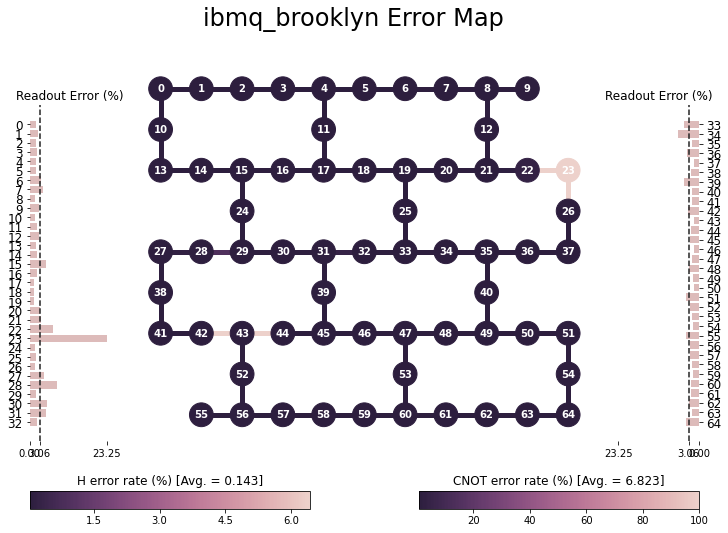

In [5]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

plot_error_map(backend)

In [6]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.ccx(0,1,2)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
#     total_circ.measure_all()
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    return total_circ

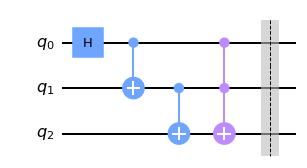

In [7]:
single_iter(n_qubits).draw("mpl")

18


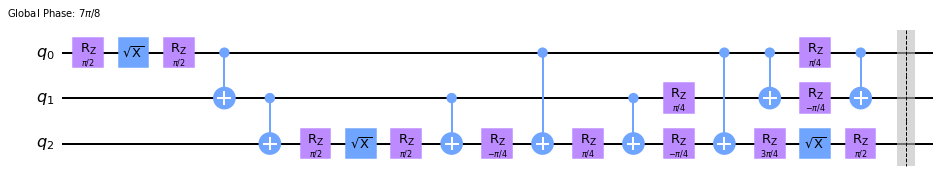

In [8]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [9]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 244
T1: 8.90717291711007e-05 sec
T2: 0.00012679963168682533 sec
Circuit Operation Time: 5.395911111111111e-05 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [10]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [11]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(iter_den.probabilities())
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.8835359153557552
0.7759250842170098
0.6683376803718879
0.58295134236954
0.5233099372760229
0.47709252973157196
0.4364504284535742
0.4053958781822416
0.36795707920975795
0.3352233843317697

Prob Vec
[0.49138488 0.01541747 0.0059447  0.46128461 0.00480208 0.00923051
 0.00468965 0.00724611]
[0.25495647 0.23130939 0.01371048 0.23716859 0.01918997 0.01322181
 0.2189644  0.0114789 ]
[0.03541816 0.13535214 0.11298628 0.42736671 0.02765404 0.12030861
 0.12025974 0.02065433]
[0.09324336 0.08010132 0.07364016 0.08236097 0.09967056 0.0736573
 0.43056181 0.06676453]
[0.13828184 0.03688848 0.11348546 0.04034433 0.14199348 0.36347917
 0.1221837  0.04334355]
[0.10384827 0.07280077 0.08160357 0.07748936 0.41700317 0.08514114
 0.08215562 0.0799581 ]
[0.054566   0.11695123 0.04502896 0.12428761 0.35836826 0.12154951
 0.04689073 0.13235771]
[0.09596774 0.08259665 0.09280407 0.08193941 0.37913626 0.08724127
 0.08740129 0.09291331]
[0.12626528 0.12596192 0.05762252 0.05741878 0.13512562 0.12944269

## State Tomography

In [12]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067572 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067629 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067180 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [13]:
np.random.seed(7)

tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=den_simu_for_tomo)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=np.random.randint(10**8)).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.7739230261487611
0.6398317784438902
0.5675954818725587
0.4918757073673201
0.46433688976146564
0.42955253742359323
0.3802372143592366
0.3534199985457057
0.3023944430881078
0.29508611891004777

Tomography Prob Vec
[0.48822557 0.02753934 0.02898938 0.41685193 0.00693996 0.01208997
 0.00796145 0.01140241]
[0.25208876 0.22962782 0.03181966 0.21931966 0.02758789 0.01879883
 0.20510525 0.01565213]
[0.04120551 0.14282227 0.12171766 0.39911567 0.03447808 0.12209744
 0.11238607 0.0261773 ]
[0.09871419 0.08759223 0.08536784 0.0745714  0.11618381 0.05948893
 0.40003798 0.07804362]
[0.14862739 0.04337565 0.1175944  0.03708225 0.16457791 0.33308919
 0.10424805 0.05140516]
[0.12554253 0.06152344 0.07014974 0.08816189 0.41037326 0.08333333
 0.08382161 0.07709418]
[0.066352   0.12358941 0.04909939 0.12000868 0.3492296  0.11154514
 0.04779731 0.13237847]
[0.10674371 0.08629015 0.10457357 0.0714247  0.36656359 0.08862305
 0.08770074 0.08808051]
[0.13647461 0.1206326  0.0597602  0.0673

## Kalman Smoother

In [14]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [15]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [16]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.02 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs, dtype=complex)* 0.1 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.05 * (1)# 

In [17]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [18]:
total_smoother_dens = []
total_smoother_purs = []

observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
#     x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll -6900.82, Last ll -6910.82
Iteration     1, New log-likelihood -6.59134e+03, Last log-likelihood -6.90082e+03, Change 3.09483e+02


Only use the estimation in the final iteration as the valid output

In [19]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
#     # Normalization
#     x_est = np.array(x_seq[-1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

# #     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# # #     x_est = (x_est+x_est.H)/2
# #     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [20]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [21]:
with np.printoptions(precision=3, suppress=True):
#     for den in total_smoother_dens:
#         print(den)
    print(total_smoother_dens[8])

[[ 0.105-0.j -0.037-0.j  0.127+0.j  0.02 +0.j -0.091-0.j  0.123+0.j
   0.083+0.j  0.003+0.j]
 [-0.037+0.j  0.043+0.j -0.036-0.j -0.022-0.j -0.019+0.j -0.026+0.j
   0.011-0.j -0.005-0.j]
 [ 0.127-0.j -0.036+0.j  0.2  +0.j  0.004+0.j -0.171-0.j  0.162-0.j
   0.101+0.j -0.011+0.j]
 [ 0.02 -0.j -0.022+0.j  0.004-0.j  0.035+0.j  0.027+0.j -0.017-0.j
  -0.005-0.j -0.007-0.j]
 [-0.091+0.j -0.019-0.j -0.171+0.j  0.027-0.j  0.227+0.j -0.143+0.j
  -0.116+0.j -0.002-0.j]
 [ 0.123-0.j -0.026-0.j  0.162+0.j -0.017+0.j -0.143-0.j  0.208+0.j
   0.135+0.j  0.015+0.j]
 [ 0.083-0.j  0.011+0.j  0.101-0.j -0.005+0.j -0.116-0.j  0.135-0.j
   0.141+0.j -0.014+0.j]
 [ 0.003-0.j -0.005+0.j -0.011-0.j -0.007+0.j -0.002+0.j  0.015-0.j
  -0.014-0.j  0.042+0.j]]


In [22]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.9134361168422223
0.8439286149231892
0.791887804173955
0.7553620843290382
0.7128605847723413
0.6654211398058926
0.6130465401179036
0.5616224046441922
0.5116493469664126
0.49278082410094687


## Check the fidelity between estimated state and the real state in the simulator

In [23]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

Iteration 1 KS Fid: 0.3747558482574834 Tomo Fid: 0.9571702560232432
Iteration 2 KS Fid: 0.17266582608170478 Tomo Fid: 0.9496811198400872
Iteration 3 KS Fid: 0.5753388571963917 Tomo Fid: 0.9713246444003416
Iteration 4 KS Fid: 0.12444159600067219 Tomo Fid: 0.9750132745006005
Iteration 5 KS Fid: 0.21621441893273055 Tomo Fid: 0.9749509184710479
Iteration 6 KS Fid: 0.3048970310224624 Tomo Fid: 0.9620130626068047
Iteration 7 KS Fid: 0.23334454297768867 Tomo Fid: 0.9765008016781469
Iteration 8 KS Fid: 0.32653077353738663 Tomo Fid: 0.9773657256450683
Iteration 9 KS Fid: 0.3246790536228033 Tomo Fid: 0.9831418330133606
Iteration 10 KS Fid: 0.3664348481796449 Tomo Fid: 0.9829075056879365


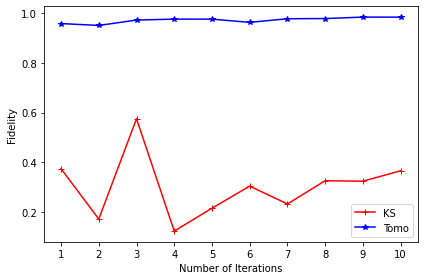

In [24]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

Iteration 1 KS Fid: 0.37475585060120997 Tomo Fid: 0.9571702600524664
Iteration 2 KS Fid: 0.17266582694949575 Tomo Fid: 0.9496811198400884
Iteration 3 KS Fid: 0.5753388583220053 Tomo Fid: 0.971324644400346
Iteration 4 KS Fid: 0.1244415945913524 Tomo Fid: 0.9750132745006033
Iteration 5 KS Fid: 0.21621441661471402 Tomo Fid: 0.9749509184710481
Iteration 6 KS Fid: 0.3048970299871266 Tomo Fid: 0.9620130626068095
Iteration 7 KS Fid: 0.2333445422062825 Tomo Fid: 0.9765008016781446
Iteration 8 KS Fid: 0.32653077281710713 Tomo Fid: 0.9773657256450694
Iteration 9 KS Fid: 0.32467905007616255 Tomo Fid: 0.9831418330133603
Iteration 10 KS Fid: 0.3664348466340221 Tomo Fid: 0.9829075056879365


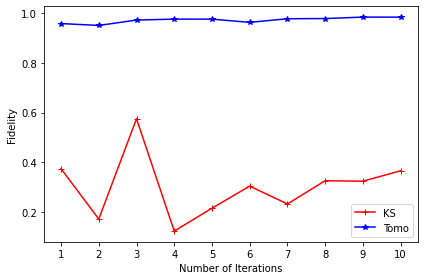

In [25]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Fid: 0.37475585060120997 Tomo Fid: 0.9571702600524664
Iteration 2 KS Fid: 0.17266582694949575 Tomo Fid: 0.9496811198400884
Iteration 3 KS Fid: 0.5753388583220053 Tomo Fid: 0.971324644400346
Iteration 4 KS Fid: 0.1244415945913524 Tomo Fid: 0.9750132745006033
Iteration 5 KS Fid: 0.21621441661471402 Tomo Fid: 0.9749509184710481
Iteration 6 KS Fid: 0.3048970299871266 Tomo Fid: 0.9620130626068095
Iteration 7 KS Fid: 0.2333445422062825 Tomo Fid: 0.9765008016781446
Iteration 8 KS Fid: 0.32653077281710713 Tomo Fid: 0.9773657256450694
Iteration 9 KS Fid: 0.32467905007616255 Tomo Fid: 0.9831418330133603
Iteration 10 KS Fid: 0.3664348466340221 Tomo Fid: 0.9829075056879365


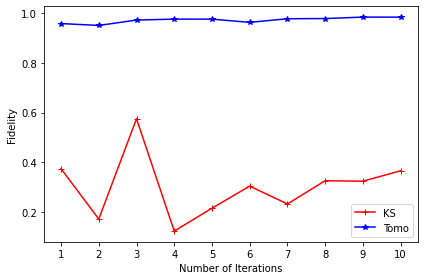

In [26]:
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 1.0669280696931769 Tomo Norm: 0.09533278326491781
Iteration 2 KS Norm: 1.1866827358402803 Tomo Norm: 0.11464162181813652
Iteration 3 KS Norm: 0.767461412472664 Tomo Norm: 0.09932087879063743
Iteration 4 KS Norm: 1.1212372291147628 Tomo Norm: 0.1008182358852837
Iteration 5 KS Norm: 1.0417845865630346 Tomo Norm: 0.0903369085908268
Iteration 6 KS Norm: 0.911940304151904 Tomo Norm: 0.0967974746443194
Iteration 7 KS Norm: 0.9544693250442373 Tomo Norm: 0.09856010057666749
Iteration 8 KS Norm: 0.8838300956977456 Tomo Norm: 0.09699872614346153
Iteration 9 KS Norm: 0.8284502368169455 Tomo Norm: 0.10027109886604624
Iteration 10 KS Norm: 0.7853664471627246 Tomo Norm: 0.09010488936661976


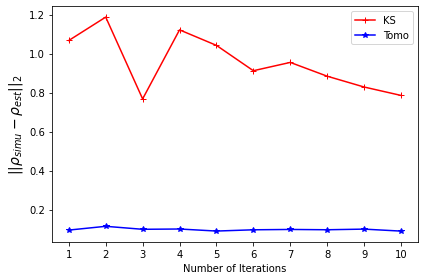

In [27]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()

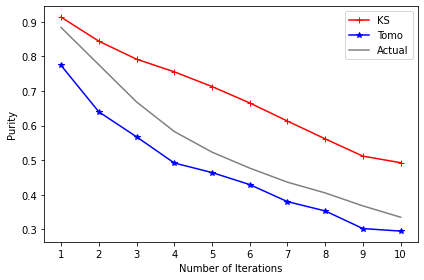

In [28]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur.svg")
plt.show()

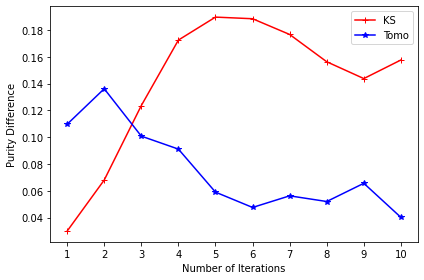

In [29]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()